##Temporal Variability Of Delays

**Imports**

Bellow are the imports needed

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, minute, second, udf, to_timestamp, unix_timestamp, mean, stddev
from datetime import datetime, timedelta
from pyspark.sql.types import IntegerType, FloatType, TimestampType
from scipy.optimize import curve_fit
from pyspark.sql import functions as F

**Part 1**

The below code:

*   Filters the dataset to include only flights operated by airline "WN", departing from "LAX", and with arrival delays greater than 0.
*  Using MapReduce logic, it groups the filtered data by SCHEDULED_DEPARTURE and calculates the total delay for each departure time.
*   Combines the calculated total delays (TOTAL_DELAY) back with the original filtered data for detailed analysis.
*  Sorts the results by SCHEDULED_DEPARTURE to show the data in chronological order, ready for further analysis or visualization.
*  Displays the aggregated delays (TOTAL_DELAY), grouped by SCHEDULED_DEPARTURE.










In [ ]:
spark = SparkSession.builder.appName("TemporalVariability").getOrCreate()

file_path = "cleaned.csv"
dataFrame = spark.read.csv(file_path, header=True, inferSchema=True)

airline = 'WN'
selected_origin_airport = "LAX"

filtered_df = dataFrame.filter(
    (col("AIRL") == airline) &
    (col("ORIGIN_AIRPORT") == selected_origin_airport) &
    (col("ARRIVAL_DELAY") > 0)
)

delay_rdd = (
    filtered_df.select("SCHEDULED_DEPARTURE", "ARRIVAL_DELAY")
    .rdd.map(lambda row: (row["SCHEDULED_DEPARTURE"], row["ARRIVAL_DELAY"]))
    .reduceByKey(lambda x, y: x + y)
)

if delay_rdd.isEmpty():
  print("No Data")
else:
  delay_df = delay_rdd.toDF(["SCHEDULED_DEPARTURE", "TOTAL_DELAY"])

  result_df = filtered_df.join(delay_df, on="SCHEDULED_DEPARTURE", how="inner")

  sorted_df = result_df.orderBy("SCHEDULED_DEPARTURE")

  delay_df.show()



+-------------------+-----------+
|SCHEDULED_DEPARTURE|TOTAL_DELAY|
+-------------------+-----------+
|2022-01-01 09:55:00|      292.0|
|2022-01-01 10:55:00|        4.0|
|2022-01-01 11:15:00|       12.0|
|2022-01-01 11:25:00|       10.0|
|2022-01-01 12:15:00|       52.0|
|2022-01-01 12:35:00|        1.0|
|2022-01-01 13:00:00|        1.0|
|2022-01-01 13:50:00|       33.0|
|2022-01-01 14:20:00|       45.0|
|2022-01-01 14:25:00|       33.0|
|2022-01-01 14:45:00|       25.0|
|2022-01-01 14:55:00|       41.0|
|2022-01-01 15:00:00|       21.0|
|2022-01-01 15:10:00|       29.0|
|2022-01-01 16:25:00|       65.0|
|2022-01-01 16:45:00|        2.0|
|2022-01-01 17:20:00|       39.0|
|2022-01-01 18:15:00|       54.0|
|2022-01-01 18:55:00|       41.0|
|2022-01-01 20:00:00|        3.0|
+-------------------+-----------+
only showing top 20 rows



**Part 2**

The below code:
*  Converts SCHEDULED_DEPARTURE to timestamps for accurate time-based analysis.
*   Prepares data by converting the filtered Spark DataFrame into a Pandas DataFrame.
*  Checks if data is available; if not, prints a message.
*   Plots a line graph with departure time on the x-axis and delay in minutes on the y-axis.
*   Displays the plot to visualize delay trends over time.






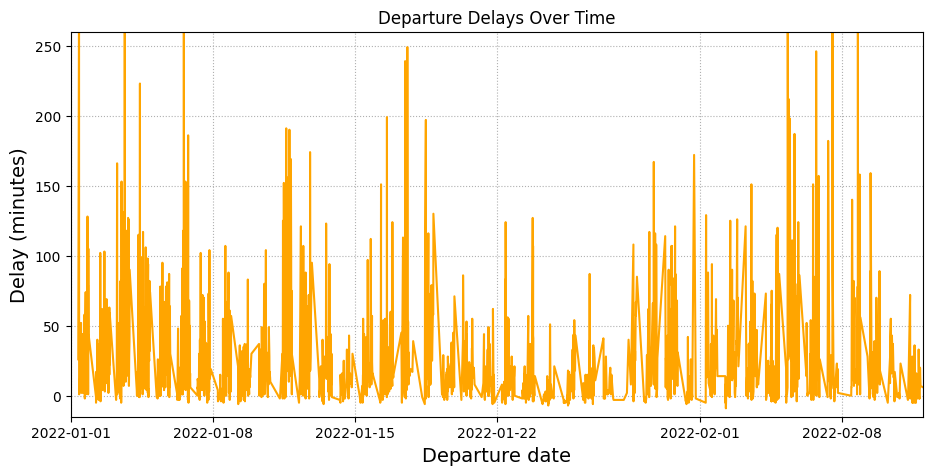

In [ ]:
# The earlier code aggregates delays (TOTAL_DELAY) for each scheduled
# departure time, while this code visualizes individual departure delays

sorted_df2 = sorted_df.withColumn("SCHEDULED_DEPARTURE", to_timestamp(col("SCHEDULED_DEPARTURE")))

plot_df = sorted_df2.select("SCHEDULED_DEPARTURE", "DEPARTURE_DELAY").orderBy("SCHEDULED_DEPARTURE").toPandas()

if not plot_df.empty:
    x = plot_df["SCHEDULED_DEPARTURE"]
    y = plot_df["DEPARTURE_DELAY"]
    plt.figure(figsize=(11, 5))
    plt.plot(x, y, linestyle='-', color="orange")
    plt.ylabel("Delay (minutes)", fontsize=14)
    plt.xlabel("Departure date", fontsize=14)
    plt.xlim([datetime(2022, 1, 1), datetime(2022, 2, 12)])
    plt.ylim([-15, 260])
    plt.grid(True, linestyle=":")
    plt.title("Departure Delays Over Time")
    plt.show()
else:
    print("No data available for plotting after filtering.")

**Part 3**

The below code:

* Adds a new column combining a placeholder date (2022-01-01) with departure times for consistent date-time formatting.
* Converts the PySpark DataFrame to a Pandas DataFrame for easier manipulation and analysis.
* Groups data by the new combined departure time column and calculates the mean and standard deviation of DEPARTURE_DELAY.
* Prepares x (time in seconds) and y (mean delays) values for curve fitting using a quadratic function.
* Fits a quadratic curve to the mean delay data and adds the fitted values to the statistics DataFrame.
* Plots:
  *   Scatter plot of original delay data points.
  *   Line plot of mean delay values over time.
  *   Fitted quadratic curve to show trends in delays.


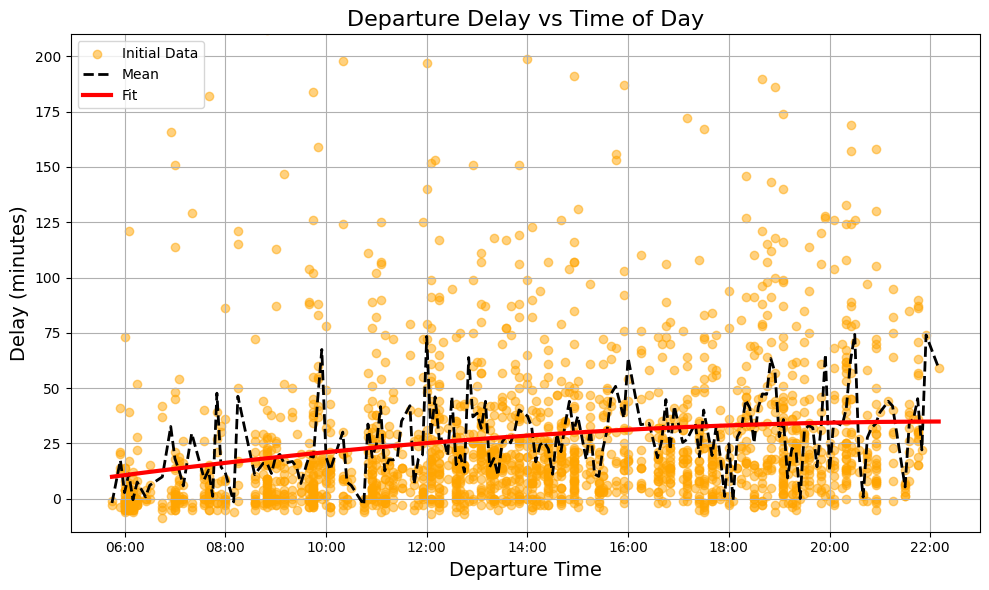

In [ ]:
placeholder_date = datetime.strptime("2022-01-01", "%Y-%m-%d")

combine_time_udf = udf(
    lambda x: datetime.combine(placeholder_date, x.time()) if x is not None else None,
    TimestampType()
)

sorted_df2 = sorted_df2.withColumn(
    "full_departure_time", combine_time_udf(col("SCHEDULED_DEPARTURE"))
)

df_pd = sorted_df2.select("full_departure_time", "DEPARTURE_DELAY").toPandas()

df_stats = (
    df_pd.groupby("full_departure_time")["DEPARTURE_DELAY"]
    .agg(["mean", "std"])
    .reset_index()
)

x_val = np.array(
    [(t - placeholder_date).total_seconds() for t in df_stats["full_departure_time"]]
)

y_val = df_stats["mean"]

def curveFit(x, a, b, c):
    return a * x**2 + b * x + c

popt, pcov = curve_fit(curveFit, x_val, y_val, p0=[1, 2, 3])

df_stats["fit"] = curveFit(x_val, *popt)

plt.figure(figsize=(10, 6))

plt.scatter(df_pd["full_departure_time"], df_pd["DEPARTURE_DELAY"], alpha=0.5, label="Initial Data", color="orange")

plt.plot(df_stats["full_departure_time"], df_stats["mean"], linestyle="--", linewidth=2, label="Mean", color="black")

plt.plot(df_stats["full_departure_time"], df_stats["fit"], color="red", linestyle="-", linewidth=3, label="Fit")

plt.title("Departure Delay vs Time of Day", fontsize=16)
plt.xlabel("Departure Time", fontsize=14)
plt.ylabel("Delay (minutes)", fontsize=14)
plt.ylim(-15, 210)
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
plt.show()